In [0]:
import numpy as np

In [0]:
import matplotlib.pyplot as plt

In [0]:
import cv2
from keras.optimizers import RMSprop

In [0]:
import os
from gtts import gTTS

In [0]:
from collections import Counter

In [0]:
from keras.applications.resnet50 import ResNet50,preprocess_input
from keras.preprocessing.image import load_img,image,img_to_array

In [0]:
from keras.models import Model

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
from keras.utils import to_categorical

In [0]:
from keras.preprocessing.sequence import pad_sequences

In [0]:
from keras.layers import *

In [0]:
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint,EarlyStopping

In [0]:
os.listdir()

['.ipynb_checkpoints',
 'encode_img.txt',
 'Flickr8k.token.txt',
 'Flickr_8k.devImages.txt',
 'Flickr_8k.testImages.txt',
 'Flickr_8k.trainImages.txt',
 'glove.6B.50d.txt',
 'Image Captioning.ipynb',
 'Images',
 'model.h5']

In [0]:
Images = os.listdir('Images')

In [0]:
f1 = open('Flickr8k.token.txt')
text = f1.read()
f1.close()

In [0]:
cap_img = text.split('\n')

In [0]:
del cap_img[-1]

In [0]:
vocab = []
caption_img_data = {}
for i in range(len(cap_img)):
    img_n_cap = cap_img[i].split('\t')
    image = img_n_cap[0][:-6]
    caption = img_n_cap[1][:-2]
    for j in caption.split():
        if len(j) > 1:
            vocab.append(j.lower())
    caption = "start " + caption + " end"
    if caption_img_data.get(image):
        caption_img_data[image].append(caption)
    else : 
        caption_img_data[image] = []
        caption_img_data[image].append(caption) 

In [0]:
ctr = Counter(vocab)

ctr = dict(ctr)

In [0]:
vocab_map = sorted(ctr.items() , key = lambda x:x[1] , reverse = True)

In [0]:
vocabulary = []
for i in range(len(vocab_map)):
    if vocab_map[i][1] > 10:
        vocabulary.append(vocab_map[i][0])

In [0]:
vocab_dic = {}
for i in range(len(vocabulary)):
    vocab_dic[vocabulary[i]] = i+1
    

In [0]:
maximum = -1
for i in caption_img_data.keys():
    for j in caption_img_data[i]:
        if len(j) > maximum:
            maximum = len(j)
    

In [0]:
maximum

30

In [0]:
vocab_dic['start'] = 1889

In [0]:
vocab_dic['end'] = 1890

In [0]:
for i in caption_img_data.keys():
    for j in range(len(caption_img_data[i])):
        aux_list = []
        for word in caption_img_data[i][j].split():
            if word in vocab_dic:
                aux_list.append(vocab_dic[word])

        caption_img_data[i][j] = aux_list        

In [0]:
f1 = open('Flickr_8k.trainImages.txt')
text_train = f1.read()
f1.close()

In [0]:
model = ResNet50(include_top = True , weights = 'imagenet' , input_shape= (224, 224, 3))

In [0]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [0]:
model = Model(model.input,model.layers[-2].output)

In [0]:
train_images = text_train.split('\n')

## Creating Dataset

In [0]:
def preprocessing_data(img):
    img = image.load_img("Images/"+img,target_size=(224,224,3))
    img = img_to_array(img)
    img = preprocess_input(img)
    img = np.expand_dims(img,axis = 0)
    img = model.predict(img)
    return img

In [0]:
def encoder_image(Images):
    encode_img={}
    for i in Images:
        img = preprocessing_data(i)
        encode_img[i] = img
    return encode_img    

In [0]:
encode_img = encoder_image(Images)

In [0]:
encode_img['1000268201_693b08cb0e.jpg'][0]

array([0.04154296, 0.17076096, 0.29278585, ..., 0.050896  , 0.31322375,
       0.8600747 ], dtype=float32)

In [0]:
dict_img = str(encode_img)

In [0]:
f1 = open("encode_img.txt","w")
f1.write(dict_img)
f1.close()

In [0]:
vocab_size = len(vocab_dic)

In [0]:
def data_generator(encode_img,caption_img_data,max_len,batch_size):
    
    X_text,X_images,y_train = [],[],[]
    
    n = 0
    
    while True:
    
        for i in range(len(train_images)):
            n+=1
            for j in caption_img_data[train_images[i][:-4]]:
                for k in range(1,len(j)):
                    in_seq = j[0:k]
                    out_seq = j[k]              

                    in_seq = pad_sequences([in_seq] , maxlen = max_len , padding = 'post')[0]

                    X_images.append(encode_img[train_images[i]].reshape(2048,))
                    X_text.append(in_seq)
                    y_train.append(out_seq)


            if n%batch_size == 0:
                yield [[np.array(X_images),np.array(X_text)],np.array(to_categorical(y_train))]            
                X_images = []
                X_text = []
                y_train = []
                

## GLOVE embedding ONE HOT ENCODING

In [0]:
os.listdir()

['.ipynb_checkpoints',
 'encode_img.txt',
 'Flickr8k.token.txt',
 'Flickr_8k.devImages.txt',
 'Flickr_8k.testImages.txt',
 'Flickr_8k.trainImages.txt',
 'glove.6B.50d.txt',
 'Image Captioning.ipynb',
 'Images',
 'model.h5']

In [0]:
fobj = open('glove.6B.50d.txt',encoding="utf8")
words_embd = fobj.read()

fobj.close()

In [0]:
word_vector = words_embd.split('\n')
word_vocab = {}

In [0]:
for i in range(len(word_vector)):
    word_arr = word_vector[i].split()
    word_vocab[word_arr[0]] = np.array(word_arr[1:]).astype('float16')

In [0]:
def GetEmbeddingMatrix():
    embedded_output = np.zeros((1891,50))
    
    for i in range(1,1891):
        if indx_to_word[i] in word_vocab:
            embedded_output[i] = word_vocab[indx_to_word[i]]
        
    return embedded_output

In [0]:
embedded_output = GetEmbeddingMatrix()

In [0]:
c = 1
indx_to_word = {} 
for i in vocab_dic.keys():
    indx_to_word[c] = i
    c+=1

## MODEL

In [0]:
input_img_feature = Input(shape=(2048,))
dr = Dropout(0.5)(input_img_feature)
Dense_1 = Dense(256,activation = 'relu')(dr)

In [0]:
input_feature = Input(shape = (30,))
embd = Embedding(input_dim=1891 , output_dim= 50 , mask_zero=True)(input_feature)
dr1 = Dropout(0.5)(embd)
input_cap = LSTM(256) (dr1)

In [0]:
decoder1 = add([Dense_1,input_cap])
decoder2 = Dense(256,activation='relu')(decoder1)
dr2 = Dropout(0.5)(decoder2)
output = Dense(1891 , activation = 'softmax')(dr2)

In [0]:
model_decoder = Model(input = [input_img_feature,input_feature] , output = output)

In [0]:
model_decoder.summary()

In [0]:
model_decoder.layers[2].set_weights = ([embedded_output])
model_decoder.layers[2].trainable = False

In [0]:
epoch =10
model_decoder.compile( loss = "categorical_crossentropy" , optimizer = 'adam' , metrics=['acc'])


In [0]:
checkpoint = ModelCheckpoint('best_model.h5',save_best_only = True,verbose = 1)
callback_list = [checkpoint]
for i in range(epoch):
    generator = data_generator(encode_img,caption_img_data,maximum,32)
    
    hist = model_decoder.fit_generator(generator,2000,epochs=1,callbacks=callback_list)
    model_decoder.save('model.h5')

## Prediction

In [0]:
f1 = open("Flickr_8k.testImages.txt",encoding = 'utf8')

In [0]:
text_images = f1.read()
f1.close()

man in black shirt and black jacket is standing in front of the man 

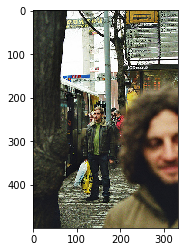

In [0]:
test_img = text_images.split()[13]
text_data = [encode_img[test_img] , np.array([1889])]
pred = -1
text_test = [1889]
while pred != 1890:
        
    pred = model_decoder.predict([encode_img[test_img] , pad_sequences([text_test] , maxlen = 30 , padding = 'post')])
    pred = np.argmax(pred)
    text_test.append(pred)
text_ = []
for i in text_test[1:-1]:
    print(indx_to_word[i] , end = " ")
    text_.append(indx_to_word[i])

text_ = " ".join(text_)
language = 
output = gTTS(text=mytext , lang = language, slow = False)

output.save("output.mp3")
os.system("start output.mp3")
    
test_img = plt.imread('Images/'+test_img)
plt.imshow(test_img)
plt.show()